In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import zscore
import os
import glob

In [2]:
data_dir = "stock_data"
stock_list = ['GME', 'AMC', 'TLRY', 'SNDL', 'ZOM', 'AAPL', 'TSLA', 'GOEV', 'PLUG']
all_data = []
for stock in stock_list:
    file_path = os.path.join(data_dir, f"{stock}_daily.csv")
    df = pd.read_csv(file_path, parse_dates=['Date'])
    df['Ticker'] = stock
    all_data.append(df)

# Combine all into one DataFrame
df = pd.concat(all_data, ignore_index=True)
df.sort_values(by=["Ticker", "Date"], inplace=True)
df.reset_index(drop=True, inplace=True)

df

,Date,Open,High,Low,Close,Volume,Ticker
0,2018-01-02 00:00:00-05:00,39.986349,40.489233,39.774854,40.479832,102223600,AAPL
1,2018-01-03 00:00:00-05:00,40.543277,41.017963,40.409333,40.472778,118071600,AAPL
2,2018-01-04 00:00:00-05:00,40.545623,40.764168,40.437528,40.660770,89738400,AAPL
3,2018-01-05 00:00:00-05:00,40.757138,41.210672,40.665491,41.123726,94640000,AAPL
4,2018-01-08 00:00:00-05:00,40.970982,41.267071,40.872282,40.970982,82271200,AAPL
...,...,...,...,...,...,...,...
12291,2023-12-22 00:00:00-05:00,0.211000,0.220000,0.210000,0.217600,4682395,ZOM
12292,2023-12-26 00:00:00-05:00,0.216800,0.228500,0.214500,0.221900,9352873,ZOM
12293,2023-12-27 00:00:00-05:00,0.222500,0.228400,0.211000,0.215000,5095105,ZOM
12294,2023-12-28 00:00:00-05:00,0.216000,0.218200,0.207000,0.210000,4325280,ZOM


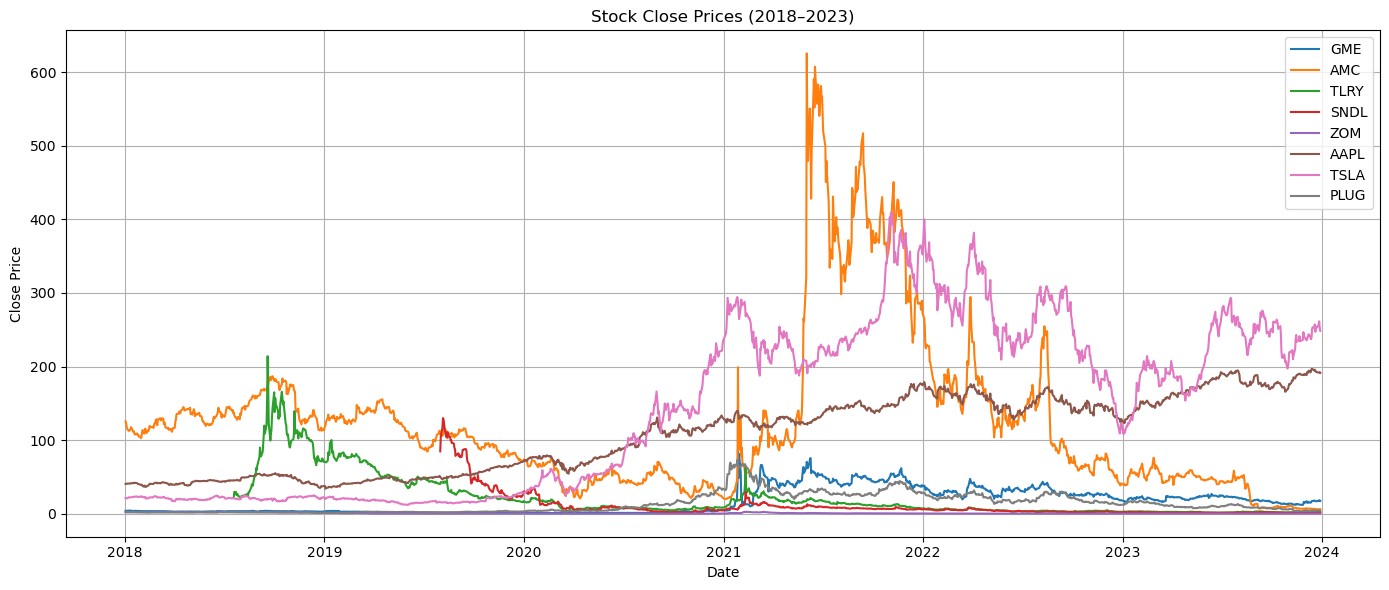

In [12]:
# Plot stock prices over time
plt.figure(figsize=(14, 6))
for ticker in stock_list:
    if ticker == 'GOEV':
        continue
    subset = df[df['Ticker'] == ticker]
    plt.plot(subset['Date'], subset['Close'], label=ticker)

plt.title('Stock Close Prices (2018–2023)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Daily Return:** Daily return measures the percentage change in a stock’s closing price from one trading day to the next. Sudden spikes or dips in return can indicate pump-and-dump schemes or price manipulation.
$$ \text{Return}_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{\Delta P_t}{P_{t-1}} $$
Where:
 * $P_t$ is the closing price on day t,
 * $P_{t-1}$ is the closing price on the previous trading day.

**Rolling Volatility (7-Day Standard Deviation):** Volatility represents how much the return varies over time. Manipulated stocks often show abnormally high short-term volatility as prices are rapidly pumped up and sold off.
$$\text{Volatility}_{t} = \sqrt{\frac{1}{n - 1} \sum{i=0}^{n-1} (R_{t-i} - \bar{R})^2}$$
Where:
* $R_t$ is the return at day t,
* $\bar{R}$ is the mean return over the 7-day window,
* and n is the rolling window size, 7

**Z-scores** help identify statistically significant deviations from the norm. A Z-score > 3 is commonly considered an outlier in a normal distribution, indicating anomalous or potentially manipulative behavior.
Z-scores are computed for Volume (unusual spikes may indicate coordinated buying/selling) and Return (extreme gains/losses may suggest artificial price inflation or dumping)
$$ Z = \frac{X - \mu}{\sigma} $$
Where:
* X is observed value,
* $\mu$ is the mean,
* $\sigma$ is the standard deviation

**If both return and volume Z-scores are greater than 3 on the same day for a given stock, it likely reflects a suspicious spike in trading behavior.**

In [3]:
# Check basic info
print(df.info())

## Pump-and-dump or insider activity often causes extreme short-term movements.

# Compute daily return and 7-day rolling volatility
df['Return'] = df.groupby('Ticker')['Close'].pct_change() # Helps spot extreme changes, one of the major flags for manipulation.
df['Volatility'] = df.groupby('Ticker')['Return'].rolling(window=7).std().reset_index(0, drop=True) # Manipulated stocks often have large price fluctuations over short windows

## Z-score > 3 indicates behavior that is statistically abnormal and may suggest manipulative events
# Z-scores for Volume and Return
df['Volume_Zscore'] = df.groupby('Ticker')['Volume'].transform(lambda x: (x - x.mean()) / x.std())
df['Return_Zscore'] = df.groupby('Ticker')['Return'].transform(lambda x: (x - x.mean()) / x.std())

df['Manipulation_Flag'] = ((df['Volume_Zscore'] > 3) & (df['Return_Zscore'] > 3)).astype(int)

df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12296 entries, 0 to 12295
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12296 non-null  object 
 1   Open    12296 non-null  float64
 2   High    12296 non-null  float64
 3   Low     12296 non-null  float64
 4   Close   12296 non-null  float64
 5   Volume  12296 non-null  int64  
 6   Ticker  12296 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 672.6+ KB
None


,Date,Open,High,Low,Close,Volume,Ticker,Return,Volatility,Volume_Zscore,Return_Zscore,Manipulation_Flag
0,2018-01-02 00:00:00-05:00,39.986349,40.489233,39.774854,40.479832,102223600,AAPL,NaN,NaN,-0.092570,NaN,0
1,2018-01-03 00:00:00-05:00,40.543277,41.017963,40.409333,40.472778,118071600,AAPL,-0.000174,NaN,0.194878,-0.070361,0
2,2018-01-04 00:00:00-05:00,40.545623,40.764168,40.437528,40.660770,89738400,AAPL,0.004645,NaN,-0.319025,0.171144,0
3,2018-01-05 00:00:00-05:00,40.757138,41.210672,40.665491,41.123726,94640000,AAPL,0.011386,NaN,-0.230121,0.508955,0
4,2018-01-08 00:00:00-05:00,40.970982,41.267071,40.872282,40.970982,82271200,AAPL,-0.003714,NaN,-0.454464,-0.247764,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12291,2023-12-22 00:00:00-05:00,0.211000,0.220000,0.210000,0.217600,4682395,ZOM,0.003690,0.076343,-0.300652,0.032187,0
12292,2023-12-26 00:00:00-05:00,0.216800,0.228500,0.214500,0.221900,9352873,ZOM,0.019761,0.072518,-0.210634,0.240736,0
12293,2023-12-27 00:00:00-05:00,0.222500,0.228400,0.211000,0.215000,5095105,ZOM,-0.031095,0.078142,-0.292697,-0.419208,0
12294,2023-12-28 00:00:00-05:00,0.216000,0.218200,0.207000,0.210000,4325280,ZOM,-0.023256,0.066950,-0.307534,-0.317481,0


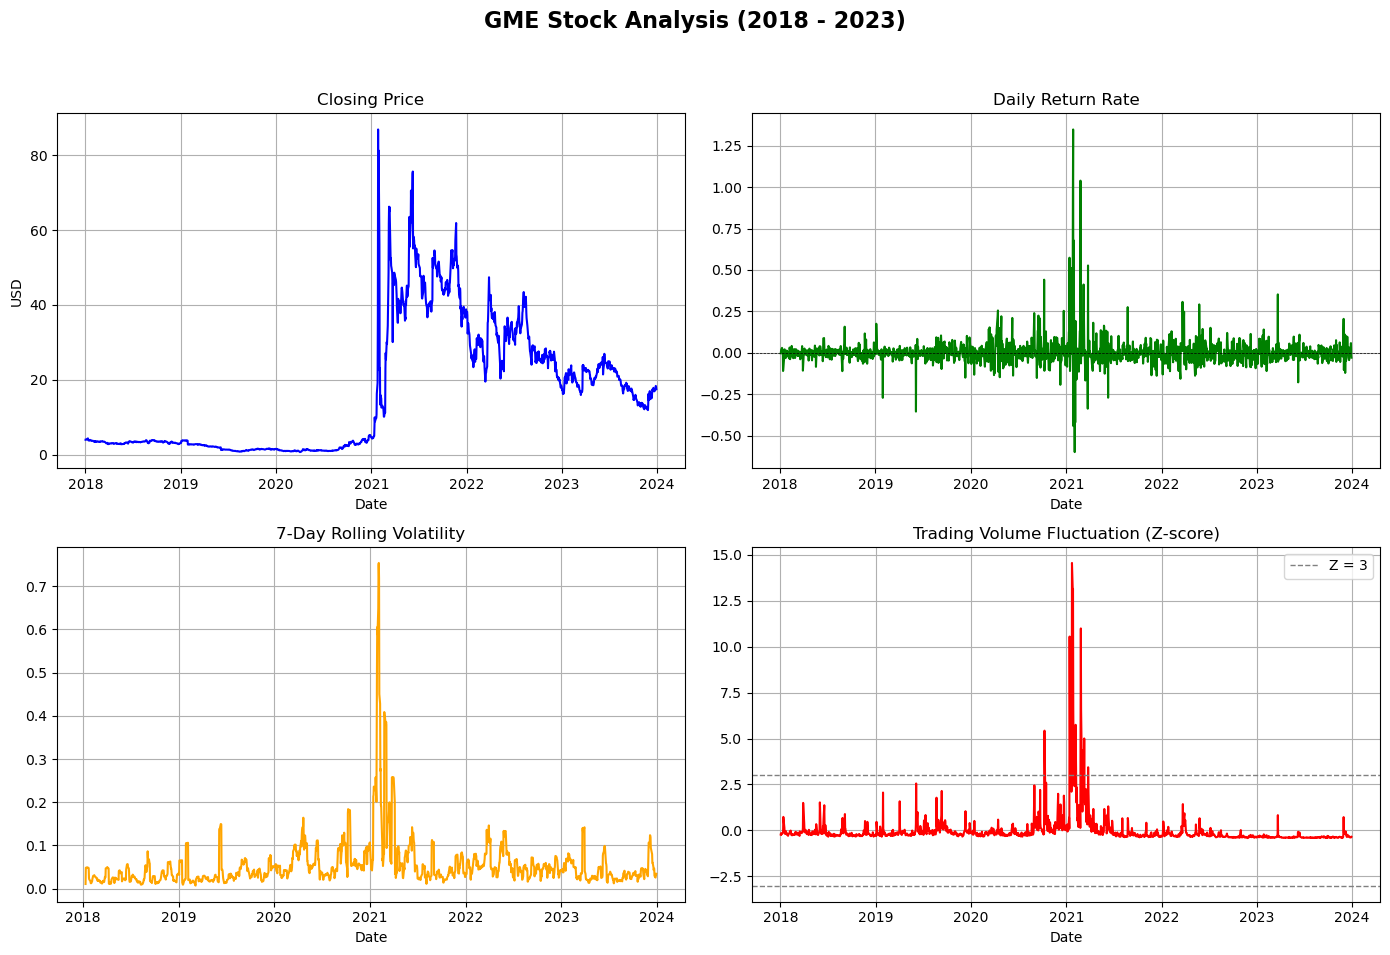

In [14]:
gme_df = df[df["Ticker"] == 'GME']

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('GME Stock Analysis (2018 - 2023)', fontsize=16, fontweight='bold')

# Plot 1: Closing Price
axs[0, 0].plot(gme_df['Date'], gme_df['Close'], color='blue')
axs[0, 0].set_title('Closing Price')
axs[0, 0].set_ylabel('USD')

# Plot 2: Daily Return Rate
axs[0, 1].plot(gme_df['Date'], gme_df['Return'], color='green')
axs[0, 1].set_title('Daily Return Rate')
axs[0, 1].axhline(0, color='black', linestyle='--', linewidth=0.5)

# Plot 3: 7-Day Rolling Volatility
axs[1, 0].plot(gme_df['Date'], gme_df['Volatility'], color='orange')
axs[1, 0].set_title('7-Day Rolling Volatility')

# Plot 4: Volume Fluctuation (Z-score)
axs[1, 1].plot(gme_df['Date'], gme_df['Volume_Zscore'], color='red')
axs[1, 1].set_title('Trading Volume Fluctuation (Z-score)')
axs[1, 1].axhline(3, color='gray', linestyle='--', linewidth=1, label='Z = 3')
axs[1, 1].axhline(-3, color='gray', linestyle='--', linewidth=1)
axs[1, 1].legend()

# Improve layout
for ax in axs.flat:
    ax.set_xlabel('Date')
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate title
plt.show()


In [9]:
# Show top suspicious events
suspicious_events = df[df['Manipulation_Flag'] == 1]
suspicious_events[['Date', 'Ticker', 'Return', 'Volume', 'Return_Zscore', 'Volume_Zscore']].sort_values(by=['Date', 'Ticker']).head()

,Date,Ticker,Return,Volume,Return_Zscore,Volume_Zscore
9734,2019-10-24 00:00:00-04:00,TSLA,0.176692,445813500,4.338131,3.736393
9802,2020-02-03 00:00:00-05:00,TSLA,0.198949,705975000,4.892193,6.846302
9803,2020-02-04 00:00:00-05:00,TSLA,0.137256,914082000,3.356388,9.333964
543,2020-03-02 00:00:00-05:00,AAPL,0.093101,341397200,4.603996,4.245526
549,2020-03-10 00:00:00-04:00,AAPL,0.072021,285290000,3.547623,3.227862


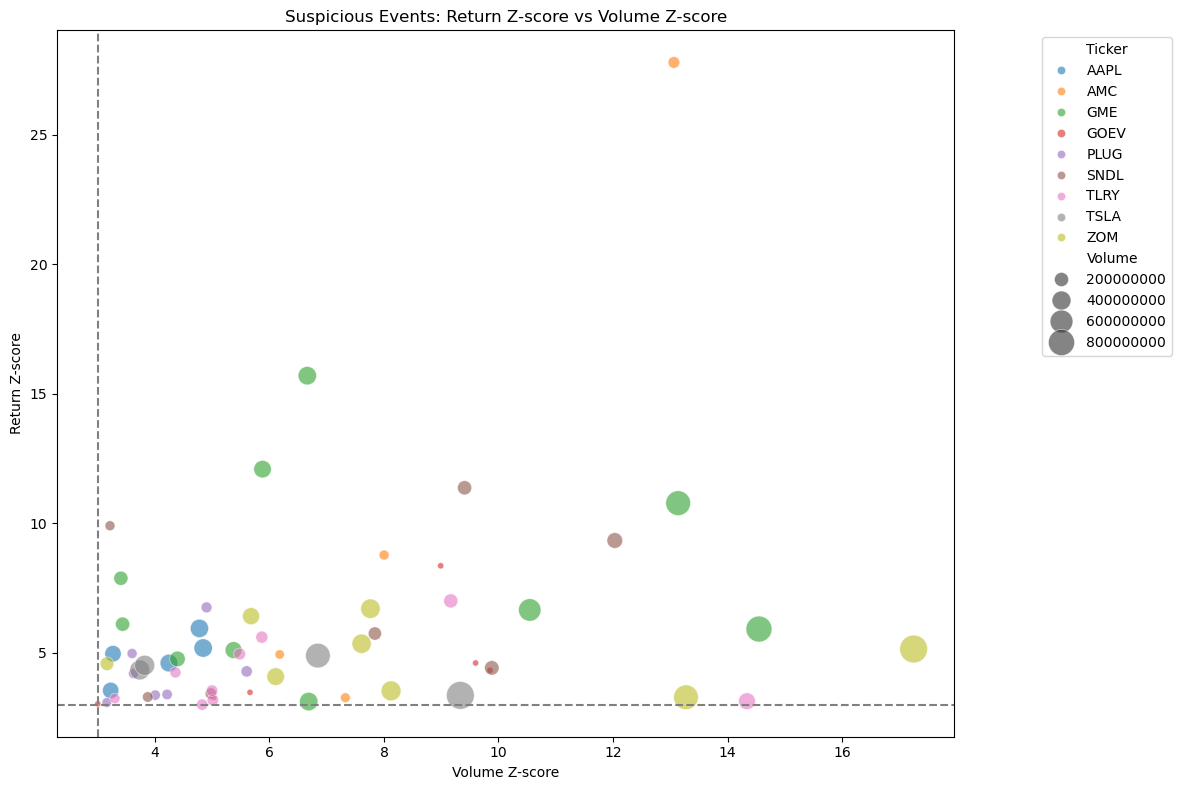

In [10]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=suspicious_events,
    x='Volume_Zscore',
    y='Return_Zscore',
    hue='Ticker',
    size='Volume',
    alpha=0.6,
    palette='tab10',
    sizes=(20, 400),
)

plt.axhline(3, linestyle='--', color='grey')
plt.axvline(3, linestyle='--', color='grey')
plt.title("Suspicious Events: Return Z-score vs Volume Z-score")
plt.xlabel("Volume Z-score")
plt.ylabel("Return Z-score")
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()

In [7]:
for ticker in df['Ticker'].unique():
    stock_data = df[df['Ticker'] == ticker]
    flagged_data = stock_data[stock_data['Manipulation_Flag'] == 1]

    fig = px.line(stock_data, x='Date', y='Close', title=f"{ticker} - Close Price with Suspicious Events")
    fig.add_scatter(x=flagged_data['Date'], y=flagged_data['Close'], mode='markers',
                    marker=dict(color='red', size=10), name='Suspicious Event')
    fig.show()